In [ ]:

"""
import librerie e file csv
"""
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



df = pd.read_csv("https://proai-datasets.s3.eu-west-3.amazonaws.com/aviation-accidents.csv")



<ipython-input-69-224db13558c7>:15: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["date"]=pd.to_datetime(df["date"], errors ='coerce')


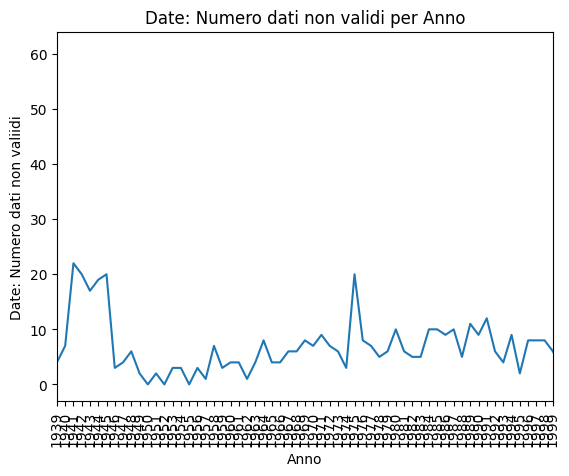

In [ ]:



"""
DATA PREPROCESSING

passaggio a formato data nella colonna Date e Anno
df["date"].value_counts()
raggruppando le date emerge che 171 incidenti datati 1940-05-10
La data corrisponde con l'invasione da parte dei tedeschi dell'Olanda e gli incidenti sono registrati quasi tutti in Olanda

accidents_1940_05_10 = df.query("date == '1940-05-10'")

Essendo un Venerdì verificherò successivamente quando farò l'analisi per giorno della settimana se questi dati infuenzeranno l'analisi

"""

df["date"]=pd.to_datetime(df["date"], errors ='coerce')

grouped = df["date"].isnull().groupby(df["year"]).sum() ##raggruppo i dati relativi alle date mancanti per ogni anno per vedere se si concentrano in un periodo particolare


plt.plot(grouped)
plt.xlabel("Anno")

plt.ylabel("Date: Numero dati non valiidi")
plt.title("Date: Numero dati non validi per Anno")
plt.xticks(rotation=90)
plt.xlim(20,80)
plt.show()## molti dei dati mancanti si concentrano tra il 1939 e il 1946



"""
passaggio a intero nella colonna fatalities e sostituzione dei valori  NaN con 0

"""

df["fatalities"] = df["fatalities"].apply(lambda x: eval(str(x)) if isinstance(x, str) and '+' in str(x) else x)
df["fatalities"] = pd.to_numeric(df["fatalities"], errors='coerce')


"""
sostituzione dei valori NaN con 0 nella colonna fatalities e conversione in int
0 è la moda ed è molto probabile che se non è stato registrato il numero di morti sia 0
df["fatalities"].mode()
"""
df["fatalities"] = df["fatalities"].fillna(0)

df["fatalities"] = df["fatalities"].astype(int)




"""
rimpiazzo valori mancanti della colonna location con "unknown"
"""

df["location"]= df["location"].fillna(df.apply(lambda x: "unknown location" if pd.isna(x["location"]) else x["location"], axis=1))


df.dropna(subset="operator", inplace=True) ## rimuovo 4 righe con valori mancanti operatore





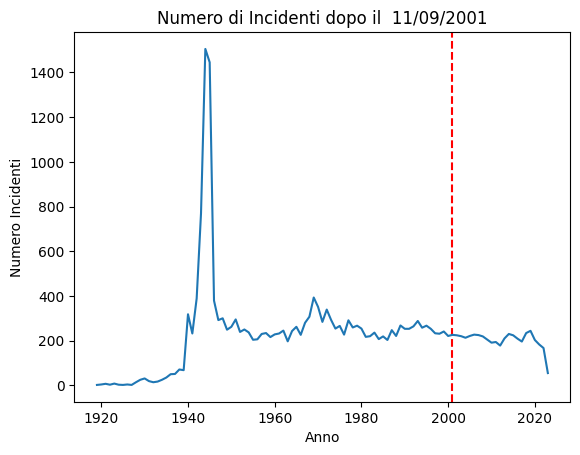

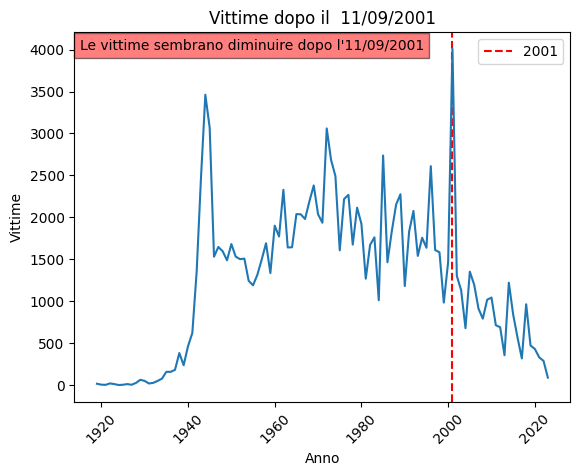

In [ ]:
"""
evoluzione incidenti dopo l'11 settembre vittime
"""


##converto year in numero per poter gestire meglio le date sull'asse delle x
df["year"] = pd.to_numeric(df["year"], downcast="integer" ,errors='coerce')


"""
evoluzione numero incidenti dopo l'11 settembre
"""
incidents_by_year = df.groupby('year')['year'].count()

plt.axvline(x=2001, color='red', linestyle='--', label='2001') ##riga rossa per identificare l'anno 2001
plt.plot(incidents_by_year)
plt.xlabel("Anno")
plt.ylabel("Numero Incidenti")
plt.title("Numero di Incidenti dopo il  11/09/2001")
plt.show()

"""
evoluzione numero morti dopo l'11 settembre
"""

fatalities_by_year = df["fatalities"].groupby(df["year"]).sum() ## raggruppo per anno sommando i decessi
plt.axvline(x=2001, color='red', linestyle='--', label='2001') ##riga rossa per identificare l'anno 2001
plt.plot(fatalities_by_year)
plt.xlabel("Anno")
plt.ylabel("Vittime")
plt.title("Vittime dopo il  11/09/2001")

plt.text(1915,4000, "Le vittime sembrano diminuire dopo l'11/09/2001",bbox=dict(facecolor='red', alpha=0.5))
plt.xticks(rotation=45)
plt.legend()
plt.show()

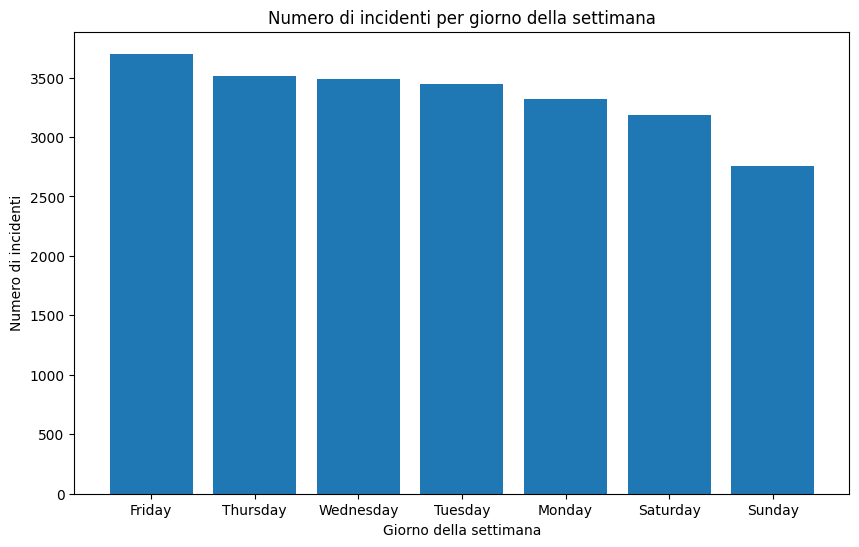

il giorno della settimana con piu' incidenti è il Venerdì con 3700 incidenti


In [ ]:
"""
Gli incidenti avvengono più di frequente durante determinati giorni della settimana?

per questo scopo, è possibile rimuovere il 2,3% dei valori non validi dalle date
Qual'ora dovesse esserci una tendenza in un particolare giorno della settimana dovrebbe essere comunque visibile

"""

df.dropna(subset=['date'], inplace=True) ##rimozione dati non validi


df["day_of_week"] = df["date"].dt.day_name() ##creazione series con il nome delle date

day_counts = df["day_of_week"].value_counts() ## conta il numero di incidenti per ogni giorno della settimana


"""
grafico a barre con numero di incidenti per ogni giorno della settimana
"""
plt.figure(figsize=(10,6))
plt.bar(day_counts.index, day_counts.values)
plt.xlabel("Giorno della settimana")
plt.ylabel("Numero di incidenti")
plt.title("Numero di incidenti per giorno della settimana")
plt.show()



print(f"il giorno della settimana con piu' incidenti è il Venerdì con {day_counts.values[0]} incidenti")



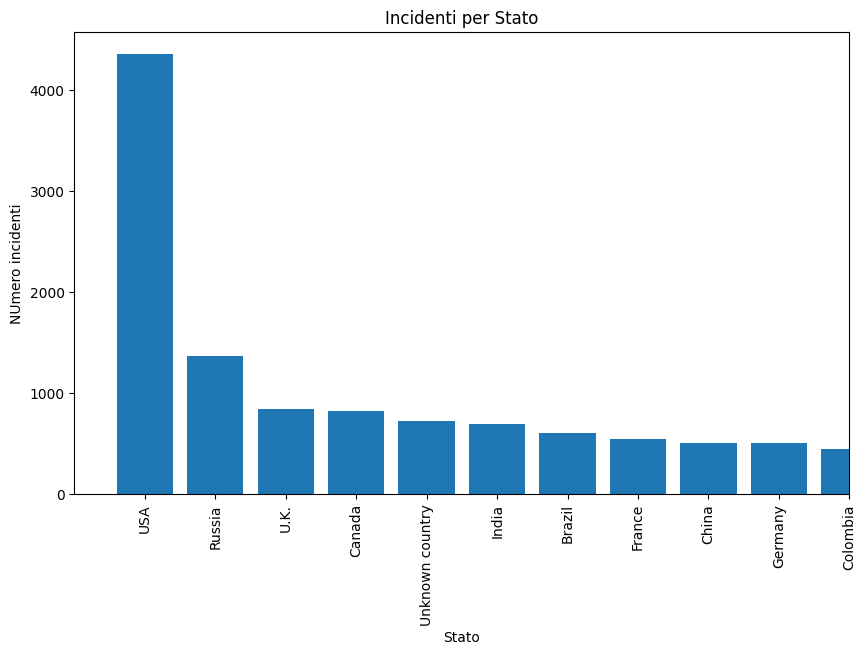

In [ ]:
"""
in quale nazione si sono verificati piu' incidenti
"""

country_counts = df["country"].value_counts()   ##conta incidenti per stato
country_counts = country_counts.sort_values(ascending=False) ## ordino incidenti in ordine decrescente
countries = country_counts.index.tolist()

"""
un numero importante di incidenti è registrato come Unknonw Country
"""

plt.figure(figsize=(10,6))
plt.bar(countries, country_counts)

plt.xlabel("Stato")
plt.ylabel("NUmero incidenti")
plt.title("Incidenti per Stato")
plt.xlim(-1, 10)
plt.xticks(rotation=90)
plt.show()


In [ ]:


saftiest_operators= df["fatalities"]==0

saftiest = df[saftiest_operators]["operator"]

Top_saftiest= saftiest.groupby(saftiest).count().sort_values(ascending=False)

print(f"{saftiest.count()} incidenti registrati hanno causato 0 vittime \n")

"""
Nella top 10 ci sono solo forze armate e qualche eccezione, occorre fare un'analisi piu' approfondita
"""

Total_incident_per_operator=df["operator"].groupby(df["operator"]).count().sort_values(ascending=True) ### calcolo il totale degli incidenti per ogni operatore

"""
per approfondire l'analisi, calcolo il rapporto vittime/incidenti (con almeno un decesso) per ogni operatore e ordino in ordine crescente.

se il risultato del rapporto è molto basso significa che il numero di vittime rispetto al totale degli incidenti per quell'operatore è molto basso e quindi l'operatore è sicuro

"""
saftiest_operators_new=df["fatalities"]>1  ##creo dataframe con numero di vittime almeno = a  1
saftiest_new = df[saftiest_operators_new]["operator"]

Top_saftiest_new= df[saftiest_operators_new].groupby('operator')["fatalities"].sum() ##raggruppo operatore sommando il numero di vittime



Statistic = (Top_saftiest_new/Total_incident_per_operator).sort_values(ascending=True)

print(f"Di seguito la top ten degli operatori che hanno registrato meno vittime rispetto al totale degli incidenti per operatore:  \n {Statistic.head(10)}")




14098 incidenti registrati hanno causato 0 vittime 

Di seguito la top ten degli operatori che hanno registrato meno vittime rispetto al totale degli incidenti per operatore:  
 operator
ZUA                        0.058824
FedEx                      0.105263
Cessna Aircraft            0.125000
Ameriflight                0.133333
Alpine Aviation            0.181818
Blue Bird Aviation         0.200000
AviaciÃ³n Nacional         0.285714
TAM Paraguay               0.285714
Perimeter Airlines         0.333333
Gouvernement du QuÃ©bec    0.333333
dtype: float64


il velivolo che ha causato piu' morti è Douglas C-47A(DC-3) con 5780 vittime


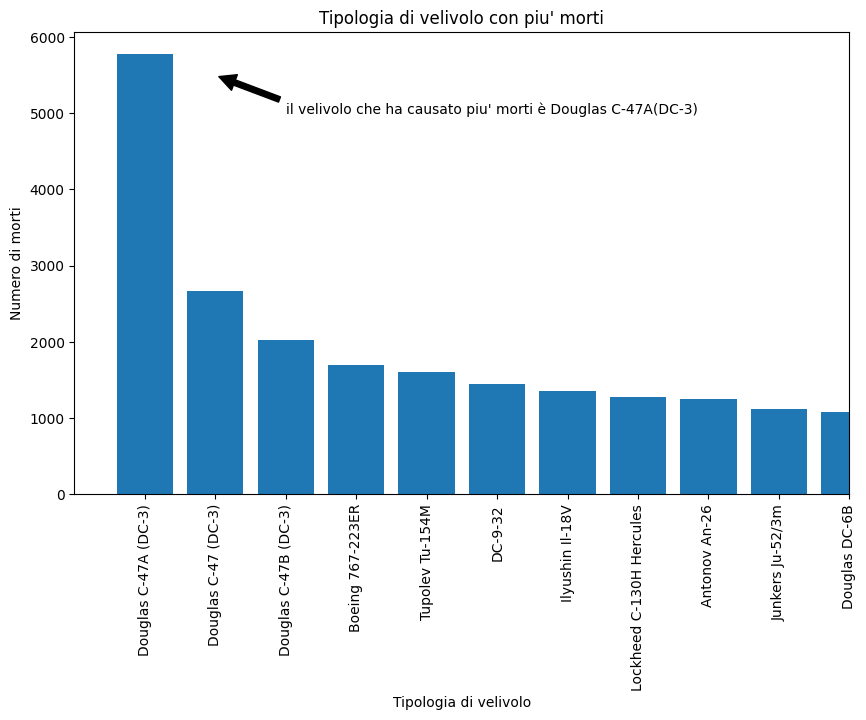

In [ ]:
"""
calcolo del velivolo che ha causato piu' morti
"""

type_top_fatalities= df.groupby("type")["fatalities"].sum().sort_values(ascending=False) ## raggruppo per tipo e sommo i decessi


"""
creo grafico a barre con numero di morti per ogni tipo di velivolo
"""
plt.figure(figsize=(10,6))
plt.bar(type_top_fatalities.index, type_top_fatalities.values)
plt.xlabel("Tipologia di velivolo")

plt.xlim(-1, 10)
plt.xticks(rotation=90)

plt.annotate("il velivolo che ha causato piu' morti è Douglas C-47A(DC-3)", xy=(1,5500), xytext=(2,5000), arrowprops=dict(facecolor="black", shrink=0.05))
plt.ylabel("Numero di morti")
plt.title("Tipologia di velivolo con piu' morti")

print(f"il velivolo che ha causato piu' morti è Douglas C-47A(DC-3) con {int(type_top_fatalities.max())} vittime")

In [ ]:
import folium

df_copy = df.copy()
incidents = df_copy["country"] != "Unknown country"
df_copy = df_copy[incidents]
incidents_country = df_copy["country"].value_counts()

incidents_country.sort_values(ascending=False)
countries = incidents_country.index.tolist()

import json
with open("world-countries.json") as f:
  world_states = json.load(f)
for item in world_states["features"]:
  item["states"]= item["properties"]["name"]

country_names_geojson = [item['properties']['name'] for item in world_states['features']]



df_copy["country"].replace("United States of America", "USA", inplace=True)
df_copy["country"].replace("United Kingdom", "UK", inplace=True)
df_copy["country"].replace("Republic of Ireland", "Ireland", inplace=True)



map = folium.Map()

folium.Choropleth(geo_data = world_states,
    data = incidents_country,
    columns=["country", "count"],
    key_on="feature.properties.name",
    bins=6,
    fill_color="YlGn",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="incidenti per stato",
    ).add_to(map)

folium.LayerControl().add_to(map)

map

<ipython-input-14-11cb0db410b9>:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy["country"].replace("United States of America", "USA", inplace=True)
<ipython-input-14-11cb0db410b9>:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(va

In [ ]:
QUERY = df_copy.query('country =="UK"')
QUERY


,date,type,registration,operator,fatalities,location,country,cat,year
